In [2]:
import os
os.environ["TAVILY_API_KEY"]=os.getenv('TAVILY_API_KEY')
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults(max_results=5)

C:\Users\Debdutta Chatterjee\AppData\Local\Temp\ipykernel_19152\1365120022.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults(max_results=5)


In [8]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(
    model = 'models/text-embedding-004',
   google_api_key =os.getenv('GOOGLE_API_KEY')
)

embeddings


text="Hello, I am learning about embeddings!"
em = embeddings.embed_query(text)

In [7]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.retrieval import create_retrieval_chain
from langchain_google_genai import ChatGoogleGenerativeAI
import os
model = ChatGoogleGenerativeAI(
                model='gemini-2.0-flash',
                google_api_key=os.getenv('GOOGLE_API_KEY'),
                temperature=0,
                max_output_tokens=1000
            )

model.invoke('Hello')

AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--ab6673cf-fab5-4541-b76f-a8d951af363c-0', usage_metadata={'input_tokens': 1, 'output_tokens': 10, 'total_tokens': 11, 'input_token_details': {'cache_read': 0}})

In [9]:
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain.document_loaders import TextLoader
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter


from langchain.agents import Tool
def make_retriever_tool_from_text(file,name,desc):
    docs=TextLoader(file,encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
    vs = FAISS.from_documents(chunks, embeddings)
    retriever = vs.as_retriever()

    def tool_func(query:str)->str:
        print(f"📚 Using tool: {name}")
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)
    
    return Tool(name=name,description=desc,func=tool_func)


internal_tool_1=make_retriever_tool_from_text("langchain_intro.txt",
                                              "langchain_intro",
                                              "langchain_intro")

internal_tool_1

Tool(name='langchain_intro', description='langchain_intro', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x000001CF98EC5260>)

In [10]:
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

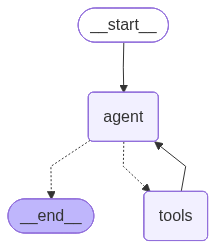

In [13]:
research_agent=create_react_agent(
    model,
    tools=[internal_tool_1,tavily],
    prompt=make_system_prompt("You can only do research. Use the tool that you are binded with, you can use both of them" \
    " You are working with a content writer colleague.")
)

research_agent

In [14]:
from typing import Literal
def research_node(state:MessagesState)-> Command[Literal["blog_generator",END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "blog_generator")

    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


In [16]:
blog_agent=create_react_agent(
    model,
    tools=[],
    prompt=make_system_prompt(
        "You can only write a detailed blog. You are working with a researcher colleague."
    )
)

def blog_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = blog_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="blog_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

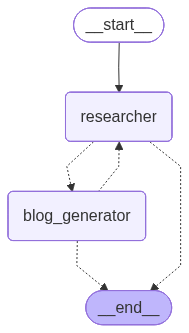

In [17]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("blog_generator", blog_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()
graph

In [18]:
response=graph.invoke({"messages":"Write a detailed blog on langchain"})
response["messages"][-1].content

"FINAL ANSWER:\n```\n## LangChain: The Open-Source Framework Revolutionizing LLM Application Development\n\nIn the rapidly evolving landscape of artificial intelligence, Large Language Models (LLMs) have emerged as powerful tools for a wide range of applications. However, harnessing the full potential of LLMs requires more than just access to the models themselves. Developers need frameworks that streamline the development process, simplify integration with external data sources, and provide the flexibility to customize LLM behavior. This is where LangChain comes in.\n\nLangChain is an open-source framework designed to simplify the creation of applications using LLMs. It provides a structured approach to building, deploying, and managing these applications, abstracting away much of the complexity involved in working with LLMs directly. Whether you're building AI chatbots, question-answering systems, or language summarization tools, LangChain offers a comprehensive set of tools and abst